In [1]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import  LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def str2num(string):
    try:
        return float(string)
    except ValueError:
        return None
    
    
def process_list(df):
    to_flat = [
             'counciltax', 'crime',  'demographic', 'education',
             'employment', 'family', 'housing', 'interests', 'newspapers',
            ]

    for each in to_flat:
        new_added_df = pd.DataFrame(df[each].values.tolist()).add_prefix(each)
        df = pd.concat([df.drop(each, axis=1), new_added_df], axis=1, join='inner')
        
    return df

def lasso_fit(X, y, alphas, do_log=False):
    pipeline = Pipeline([('scaler', StandardScaler()), ('normalizer', Normalizer())])
    X = pd.DataFrame(pipeline.fit_transform(X))
    
    if do_log:
        y = np.log1p(y)
        
    error = list(map(abs, 
                     [cross_val_score(Lasso(alpha=alpha, normalize=True, max_iter=10000), X, y,
                      scoring='neg_mean_absolute_error', cv=5).mean() for alpha in alphas]
                    )
                )
    plt.plot(alphas, error)
    plt.show()
    return list(zip(error, alphas))


def regressor(X, y, model, n=-1, alpha=5e-5, num_est = 500, do_log=False):
    
    # use all features without feature selection
    if n == -1:
        preproc_pipe = [('scaler', StandardScaler()), # column-wise
                    ('normalizer', Normalizer())] # row-wise
    else:
        preproc_pipe = [('scaler', StandardScaler()),
                    ('lsa', TruncatedSVD(n)),
                    ('normalizer', Normalizer())]
        
    preproc_pipe = Pipeline(preproc_pipe)
    X = pd.DataFrame(preproc_pipe.fit_transform(X))
    
    pipeline = []
    if model == 'GB':
        pipeline.append(('estimator', GradientBoostingRegressor(n_estimators=num_est)))
    elif model == 'LASSO':
        pipeline.append(('estimator', Lasso(alpha=alpha, max_iter=10000)))
    elif model == 'LR':
        pipeline.append(('estimator', LinearRegression()))
    else:
        print('Error Model')
        return None
    pipeline = Pipeline(pipeline) 
    
    MAE_test = []
    
    
    kf = KFold(n_splits=5, shuffle = True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if do_log:
            pipeline.fit(X_train, np.log1p(y_train))
            y_test_predict = np.expm1(pipeline.predict(X_test))
        else:
            pipeline.fit(X_train, y_train)
            y_test_predict = pipeline.predict(X_test)
        
        MAE_test.append(mean_absolute_error(y_test, y_test_predict))      
    return np.mean(MAE_test)

def get_meta(df):
    meta = df.drop(["postcode", "price", "house_id", "description"], axis=1)
    meta = process_list(meta)
    meta = meta.fillna(0)
    meta = pd.get_dummies(meta)
    return meta

def get_desc(df):
    cv = CountVectorizer(stop_words='english', 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=10)
    matrix = cv.fit_transform(df.description)
    desc_df = pd.DataFrame(matrix.todense(), 
                columns=cv.get_feature_names(),
                index = df.description.index.values)
    return desc_df


def get_model(X, y, model, n):
    if n == -1:
        preproc_pipe = [('scaler', StandardScaler()), # column-wise
                    ('normalizer', Normalizer())] # row-wise
    else:
        preproc_pipe = [('scaler', StandardScaler()),
                    ('lsa', TruncatedSVD(n)),
                    ('normalizer', Normalizer())]
        
    preproc_pipe = Pipeline(preproc_pipe)
    X = pd.DataFrame(preproc_pipe.fit_transform(X))
   
    if model == 'GB':
        model = GradientBoostingRegressor(n_estimators = 300)
    elif model == 'LASSO':
        model = Lasso(alpha=4e-5, max_iter=2000)
    else:
        print('Error Model')
        return None
    model.fit(X, np.log1p(y))
    
    result = model.predict(X)
    
    return model, np.expm1(result)

def save_model(model, name):
    joblib.dump(model, 'web/static/assets/result/' + name)
    

def single_house_predict(house_id):
    meta_model = load_model('meta_model')
    desc_model = load_model('desc_model')
    comb_model = load_model('comb_model')
    
    house = pd.read_json(house_id + ".json")
    train = pd.read_json("data/house.jl", lines=True)
    
    all_df = pd.concat([train, house], ignore_index=True)
    
    meta_house = get_meta(all_df)
    desc_house = get_desc(all_df)
    comb_house = pd.concat([meta_house, desc_house], axis=1)
    
    
    meta_pipe = Pipeline([('scaler', StandardScaler()), 
                          ('normalizer', Normalizer())])
    
    desc_pipe = Pipeline([('scaler', StandardScaler()), 
                         ('lsa', TruncatedSVD(110)),
                         ('normalizer', Normalizer())])
    
    comb_pipe = Pipeline([('scaler', StandardScaler()), 
                         ('lsa', TruncatedSVD(128)),
                         ('normalizer', Normalizer())])
    
    meta_house = meta_pipe.fit_transform(meta_house)
    desc_house = desc_pipe.fit_transform(desc_house)
    comb_house = comb_pipe.fit_transform(comb_house)
    
    
    meta = np.expm1(meta_model.predict(meta_house[-1:]))
    desc = np.expm1(desc_model.predict(desc_house[-1:]))
    comb = np.expm1(comb_model.predict(comb_house[-1:]))
    
    return meta, desc, comb

In [3]:
# load data and then check the shape of the data
train = pd.read_json("data/house.jl", lines=True)
train.shape

(753, 26)

In [4]:
train

,counciltax,crime,cs_rating,demographic,description,education,employment,en_rating,family,house_id,...,num_of_bedrooms,num_of_receptions,overall_rating,postcode,pr_rating,price,property_type,rs_rating,sp_rating,tt_rating
0,"[1234.0, 1440.0, 1646.0, 1852.0, 2263.0, 2675....","[46.86, 9.08, 13.75, 4.88, 7.8100000000000005,...",70,"[17.67, 23.28, 16.08, 11.66, 11.23, 8.53, 11.55]",Property description Three Bedroom end of te...,"[76.0, 18.0, 50.9, 86.6, 94.7]","[37.0, 50.0, 64.0, 67.0, 109.0, 230.0, 107.0]",80,"[68.0, 95.0, 239.0, 57.0, 35.0, 93.0, 138.0]",46929337,...,3.0,2.0,78,ng6 0lj,80,120000,end_terrace,80,80,80
1,"[1200.0, 1400.0, 1600.0, 1800.0, 2200.0, 2600....","[26.45, 8.4, 11.22, 1.44, 4.39, 0.39, 25.26, 6...",80,"[17.68, 11.22, 12.68, 12.21, 15.19, 12.25, 18.77]",Property features EPC Grade F Ideal First ...,"[79.0, 23.0, 66.1, 94.3, 90.7]","[58.0, 80.0, 103.0, 84.0, 131.0, 85.0, 72.0]",60,"[103.0, 102.0, 116.0, 90.0, 22.0, 100.0, 102.0]",46947122,...,4.0,2.0,79,ng15 6dz,80,115000,terraced,70,80,90
2,"[1233.0, 1438.0, 1644.0, 1849.0, 2260.0, 2671....","[23.78, 5.9, 8.86, 1.51, 3.96, 0.27, 21.65, 4.71]",80,"[16.8, 10.86, 10.88, 11.59, 15.29, 13.12, 21.46]",Property features Development Opportunity ...,"[79.0, 23.0, 66.1, 94.3, 90.7]","[170.0, 138.0, 100.0, 180.0, 66.0, 18.0, 68.0]",60,"[141.0, 128.0, 37.0, 130.0, 3.0, 58.0, 62.0]",45644741,...,NaN,NaN,78,ng25 0pj,80,185000,detached,80,90,80
3,"[1233.0, 1438.0, 1644.0, 1849.0, 2260.0, 2671....","[23.78, 5.9, 8.86, 1.51, 3.96, 0.27, 21.65, 4.71]",90,"[16.8, 10.86, 10.88, 11.59, 15.29, 13.12, 21.46]",Property features Highly sought after locat...,"[79.0, 23.0, 66.1, 94.3, 90.7]","[170.0, 138.0, 100.0, 180.0, 66.0, 18.0, 68.0]",70,"[141.0, 128.0, 37.0, 130.0, 3.0, 58.0, 62.0]",45710846,...,3.0,3.0,85,ng22 8aw,90,279950,semi_detached,90,90,70
4,"[1234.0, 1440.0, 1646.0, 1852.0, 2263.0, 2675....","[46.86, 9.08, 13.75, 4.88, 7.8100000000000005,...",70,"[17.67, 23.28, 16.08, 11.66, 11.23, 8.53, 11.55]",Property features Semi-detached house Thre...,"[76.0, 18.0, 50.9, 86.6, 94.7]","[60.0, 85.0, 106.0, 93.0, 133.0, 74.0, 67.0]",60,"[104.0, 95.0, 100.0, 112.0, 17.0, 98.0, 92.0]",47003839,...,3.0,2.0,78,ng6 9gb,80,125000,semi_detached,80,80,90
5,"[1198.0, 1397.0, 1597.0, 1797.0, 2196.0, 2595....","[20.32, 6.54, 7.62, 0.86, 2.64, 0.45, 13.99, 6...",90,"[16.05, 10.98, 13.23, 12.36, 14.6, 12.22, 20.56]",Property description Offered with no upward ...,"[79.0, 23.0, 66.1, 94.3, 90.7]","[66.0, 87.0, 118.0, 90.0, 130.0, 66.0, 74.0]",70,"[105.0, 103.0, 81.0, 122.0, 18.0, 68.0, 108.0]",46924783,...,2.0,1.0,86,ng9 6db,90,175000,semi_detached,80,90,90
6,"[1234.0, 1440.0, 1646.0, 1852.0, 2263.0, 2675....","[46.86, 9.08, 13.75, 4.88, 7.8100000000000005,...",90,"[17.67, 23.28, 16.08, 11.66, 11.23, 8.53, 11.55]",Property features Superb 2 bedroom detached...,"[76.0, 18.0, 50.9, 86.6, 94.7]","[87.0, 119.0, 129.0, 130.0, 118.0, 33.0, 48.0]",70,"[110.0, 73.0, 41.0, 224.0, 6.0, 46.0, 60.0]",46979033,...,2.0,1.0,89,ng8 2rz,100,235000,bungalow,90,90,90
7,"[1191.0, 1389.0, 1588.0, 1786.0, 2183.0, 2580....","[15.13, 4.47, 7.61, 1.26, 2.9, 0.42, 16.71, 4.44]",80,"[16.76, 10.56, 11.69, 12.62, 15.08, 12.84, 20.45]",Property features Immaculate Semi Detached ...,"[79.0, 23.0, 66.1, 94.3, 90.7]","[66.0, 87.0, 118.0, 90.0, 130.0, 66.0, 74.0]",70,"[105.0, 103.0, 81.0, 122.0, 18.0, 68.0, 108.0]",46916968,...,3.0,2.0,79,ng4 1nf,80,190000,semi_detached,80,80,80
8,"[1233.0, 1438.0, 1644.0, 1849.0, 2260.0, 2671....","[23.78, 5.9, 8.86, 1.51, 3.96, 0.27, 21.65, 4.71]",80,"[16.8, 10.86, 10.88, 11.59, 15.29, 13.12, 21.46]",Property features Six Reception Rooms Cliv...,"[79.0, 23.0, 66.1, 94.3, 90.7]","[170.0, 138.0, 100.0, 180.0, 66.0, 18.0, 68.0]",60,"[141.0, 128.0, 37.0, 130.0, 3.0, 58.0, 62.0]",45877458,...,6.0,6.0,63,ng25 0rb,80,2800000,detached,60,50,40
9,"[1100.0, 1283.0, 1466.0, 1650.0, 2016.0, 2383....","[33.84, 5.8, 8.06, 1.15, 0.78, 0.32, 11.45, 5.11]",80,"[16.89, 10.84, 12.24, 12.2, 15.77, 12.17, 19.88]",P

In [26]:
train.columns

Index(['counciltax', 'crime', 'cs_rating', 'demographic', 'description',
       'education', 'employment', 'en_rating', 'family', 'house_id', 'housing',
       'interests', 'latitude', 'longitude', 'newspapers', 'num_of_bathrooms',
       'num_of_bedrooms', 'num_of_receptions', 'overall_rating', 'postcode',
       'pr_rating', 'price', 'property_type', 'rs_rating', 'sp_rating',
       'tt_rating'],
      dtype='object')

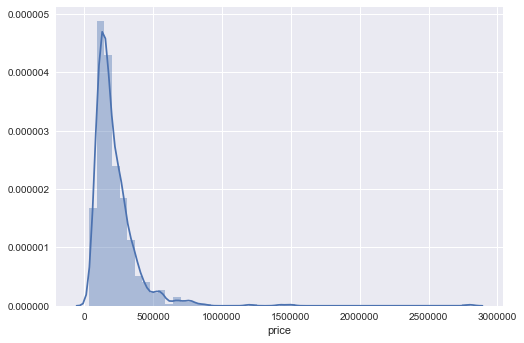

Skewness: 6.12187303657
Kurtosis: 70.5775911966


In [27]:
# Positive skew and high kurtosis
sns.distplot(train.price)
plt.show()
print("Skewness:", train.price.skew())
print("Kurtosis:", train.price.kurt())

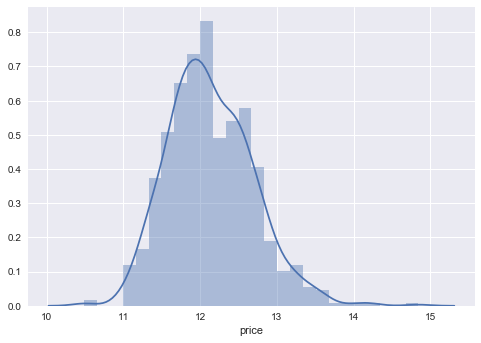

Skewness: 6.12187303657
Kurtosis: 70.5775911966


In [28]:
sns.distplot(np.log1p(train.price))
plt.show()
print("Skewness:", train.price.skew())
print("Kurtosis:", train.price.kurt())

## Meta data only

In [4]:
meta = train.drop(["postcode", "price", "house_id", "description", "latitude", "longitude"], axis=1)
meta = process_list(meta)
meta = meta.fillna(0)
meta = pd.get_dummies(meta)
meta.shape

(753, 84)

In [30]:
meta.columns

Index(['cs_rating', 'en_rating', 'num_of_bathrooms', 'num_of_bedrooms',
       'num_of_receptions', 'overall_rating', 'pr_rating', 'rs_rating',
       'sp_rating', 'tt_rating', 'counciltax0', 'counciltax1', 'counciltax2',
       'counciltax3', 'counciltax4', 'counciltax5', 'counciltax6',
       'counciltax7', 'crime0', 'crime1', 'crime2', 'crime3', 'crime4',
       'crime5', 'crime6', 'crime7', 'demographic0', 'demographic1',
       'demographic2', 'demographic3', 'demographic4', 'demographic5',
       'demographic6', 'education0', 'education1', 'education2', 'education3',
       'education4', 'employment0', 'employment1', 'employment2',
       'employment3', 'employment4', 'employment5', 'employment6', 'family0',
       'family1', 'family2', 'family3', 'family4', 'family5', 'family6',
       'housing0', 'housing1', 'housing2', 'housing3', 'housing4',
       'interests0', 'interests1', 'interests2', 'interests3', 'interests4',
       'interests5', 'interests6', 'interests7', 'newspaper

## Feature Selection

In [32]:
X_new = SelectKBest(chi2, k=2).fit(meta, train.price)
features = []
for i, column in enumerate(meta.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
features

[(0.0, 'employment0'),
 (0.0, 'employment1'),
 (0.0, 'employment2'),
 (0.0, 'employment3'),
 (0.0, 'employment4'),
 (0.0, 'employment5'),
 (0.0, 'employment6'),
 (0.0, 'family0'),
 (0.0, 'family1'),
 (0.0, 'family2'),
 (0.0, 'family3'),
 (0.0, 'family4'),
 (0.0, 'family5'),
 (0.0, 'housing0'),
 (0.0, 'housing1'),
 (0.0, 'housing2'),
 (0.0, 'housing3'),
 (0.0, 'housing4'),
 (0.0, 'interests0'),
 (0.0, 'interests1'),
 (0.0, 'interests3'),
 (0.0, 'interests4'),
 (0.0, 'interests5'),
 (0.0, 'interests7'),
 (0.0, 'newspapers0'),
 (0.0, 'newspapers1'),
 (0.0, 'newspapers2'),
 (0.0, 'newspapers3'),
 (0.0, 'newspapers4'),
 (0.0, 'newspapers5'),
 (0.0, 'newspapers6'),
 (0.0, 'newspapers7'),
 (2.6861692667424506e-264, 'interests2'),
 (1.110065102919223e-252, 'family6'),
 (1.3971121126080284e-192, 'crime0'),
 (6.8489112487172952e-160, 'interests6'),
 (7.7141836662714989e-139, 'crime6'),
 (3.9926231997652849e-71, 'counciltax7'),
 (1.3862270213863507e-50, 'counciltax6'),
 (1.2199648439610284e-37, '

## Parameter n for basic linear regression

In [107]:
ns = list(range(5, 84, 3))
linear = []
linear_withlog = []

for n in ns:
    linear.append((regressor(meta, train.price, 'LR', n), n))
linear.sort()
linear

[(62186.754151991685, 29),
 (62371.31172667582, 26),
 (63073.171174779207, 23),
 (63160.930020174244, 32),
 (63800.501666649754, 35),
 (64049.69145489193, 50),
 (65309.11015010297, 38),
 (65480.990813896802, 41),
 (65772.256736575815, 47),
 (65831.37917244836, 20),
 (66118.316738870024, 14),
 (66946.27576109764, 17),
 (67046.376812508912, 11),
 (67438.642848875927, 44),
 (67697.511188490811, 8),
 (68353.754940406565, 53),
 (73151.121716682406, 56),
 (78886.175445529836, 5),
 (227053.27690724441, 59),
 (341782.35730571242, 77),
 (467124.7363493141, 71),
 (540701.47757031641, 62),
 (606579.05608033901, 83),
 (635112.02459673095, 74),
 (48027623511276.711, 80),
 (499532057708711.81, 68),
 (777921133810330.25, 65)]

In [108]:
regressor(meta, train.price, 'LR', 30, do_log=True)

50801.802064052135

## parameter alpha for Lasso 

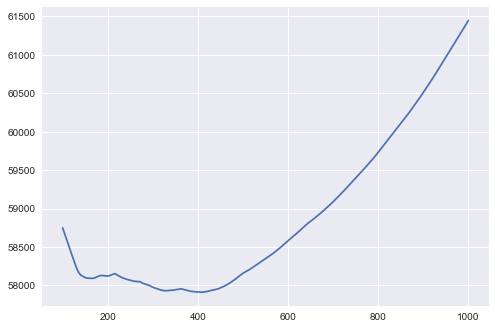

In [79]:
# brute force to find out the suitable parameter
# Without log transformation
re = lasso_fit(meta, train.price, np.linspace(100, 1000, num=500)).sort()
re

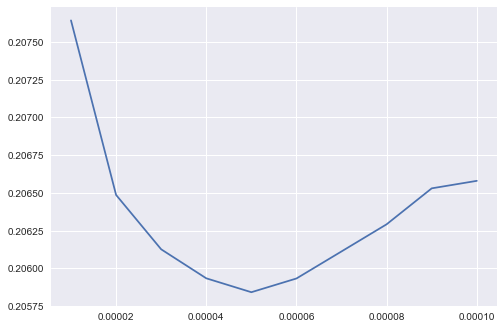

In [95]:
# brute force to find out the suitable parameter
re = lasso_fit(meta, train.price, np.linspace(1e-5, 1e-4, num=10), do_log=True).sort()
re

In [101]:
print(regressor(meta, train.price, 'LASSO', alpha=400)) #without log transformation
print(regressor(meta, train.price, 'LASSO', do_log=True))

58358.8296061
50515.4528904


## num_estimators for GBDT

In [113]:
num_ests = list(range(50, 300, 5))
gbdt = []

for num_est in num_ests:
    gbdt.append((regressor(meta, train.price,
                           'GB', num_est=num_est, do_log=True), num_est))
gbdt.sort()
gbdt

[(44633.981817145359, 80),
 (44815.807193006738, 265),
 (44847.305440837881, 85),
 (44908.057419899116, 260),
 (44993.237870316691, 75),
 (45118.134110278676, 55),
 (45196.193654101291, 290),
 (45239.695580061198, 255),
 (45351.194208619105, 170),
 (45369.233907048401, 225),
 (45370.615922428391, 215),
 (45483.644597961094, 90),
 (45689.125302986678, 70),
 (45741.765686273829, 95),
 (45832.283849586318, 205),
 (45879.167801359828, 60),
 (45897.210519658845, 120),
 (45918.677998365114, 125),
 (45987.375757799389, 175),
 (45995.765766991208, 230),
 (46000.124253273374, 180),
 (46030.916738653897, 100),
 (46060.015304913963, 65),
 (46089.90042615922, 220),
 (46114.848971808955, 115),
 (46169.062156063526, 270),
 (46186.166718557957, 145),
 (46249.572531609694, 150),
 (46295.668663282835, 140),
 (46324.942555278591, 240),
 (46345.383897587963, 50),
 (46398.630784683672, 105),
 (46408.147796072546, 200),
 (46453.650586375988, 195),
 (46511.525126616543, 165),
 (46519.594642835691, 110),
 (4

In [117]:
regressor(meta, train.price, 'GB', num_est=80, do_log=True)

47166.485915020639

# find out the best n for Lasso and GBDT

In [97]:
ns = list(range(5, 84, 3))
gb_tests = []
lasso_tests = []

for n in ns:
    gb_tests.append((regressor(meta, train.price, 'GB', n), n))
    lasso_tests.append((regressor(meta, train.price, 'LASSO', n), n))
gb_tests.sort()
print(gb_tests[:10])
lasso_tests.sort()
print(lasso_tests[:10])

/Users/nzhl/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/nzhl/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/nzhl/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/nzhl/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not conver

[(54846.707956138613, 41), (54940.608065299421, 35), (54973.383848501406, 68), (55326.093695726326, 77), (55571.188778081989, 65), (55886.957781383171, 47), (55994.649126816788, 53), (56270.624851927663, 59), (56509.664774699682, 74), (56745.725629449982, 50)]
[(61906.295967697501, 50), (62819.3254061271, 29), (63762.605405774259, 56), (63792.81638720195, 44), (63968.912368540674, 23), (64147.319182351268, 26), (64597.476686143164, 32), (64598.539611235647, 35), (64993.367501916582, 47), (65084.394718204407, 38)]


/Users/nzhl/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Description only

I found no difference with or without feature selection.


In [24]:
### cv = CountVectorizer(stop_words='english', token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", min_df=10)
matrix = cv.fit_transform(train.description)
desc_df = pd.DataFrame(matrix.todense(), columns=cv.get_feature_names(),index = train.description.index.values)

desc_df.loc[:20, ['brief','delighted', 'superb', 'fitted', 'washing', 'machine', 'friendly', 'shops', 'benefit', 'oven']]

,brief,delighted,superb,fitted,washing,machine,friendly,shops,benefit,oven
0,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,4,5,1,1,0,0,0,2
4,0,0,0,1,1,1,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0
6,0,0,2,1,0,0,0,1,0,0
7,0,0,0,4,1,1,0,0,0,1
8,0,0,1,0,0,0,0,0,0,0
9,0,1,0,0,1,1,0,1,1,0


In [15]:
# all those useful keyword 
X_new = SelectKBest(chi2, k=2).fit(desc_df, train.price)
features = []
for i, column in enumerate(desc_df.columns):
    features.append((X_new.pvalues_[i], column))
features.sort(reverse=True)
print('p-value', 'feature')
features[200:300]

p-value feature


[(0.90319123791001099, 'later'),
 (0.89898418067873742, 'identification'),
 (0.89770115539075834, 'matters'),
 (0.89521287664541627, 'descriptions'),
 (0.89491233217595101, 'care'),
 (0.89313407979915338, 'apply'),
 (0.88100520353312051, 'planning'),
 (0.87566135611781082, 'ready'),
 (0.87430482131814036, 'reliable'),
 (0.87428497034646202, 'refurbishment'),
 (0.87023346705733795, 'obtaining'),
 (0.86982911317443345, 'domestic'),
 (0.86621220722312231, 'externally'),
 (0.86321247258824996, 'hood'),
 (0.86021207055183091, 'guidance'),
 (0.85936718859719019, 'professional'),
 (0.8567036906706581, 'mile'),
 (0.85426156776659468, 'housing'),
 (0.84914031080021191, 'roads'),
 (0.84477277112137583, 'mentioned'),
 (0.84436377369400151, 'endeavour'),
 (0.84125156164283144, 'fact'),
 (0.83984857422484394, 'especially'),
 (0.83533961422819814, 'solicitor'),
 (0.8340678162909857, 'view'),
 (0.83294265030769288, 'burglar'),
 (0.83215509259085185, 'misdescriptions'),
 (0.83083771800368822, 'wide'),

## find n for linear regression

In [168]:
ns = range(50, 150, 2)
lrs = []

for n in ns:
    lrs.append((regressor(desc_df, train.price, 'LR', n=n, do_log=True), n))
lrs.sort()
lrs

[(60412.902892499304, 86),
 (61203.168210501295, 94),
 (61494.468687731693, 90),
 (61755.038830631725, 96),
 (61810.723129526057, 74),
 (61845.042157699994, 84),
 (61893.265752729414, 102),
 (61919.376302275647, 70),
 (61935.943935808587, 98),
 (61954.133882043461, 92),
 (61965.098215551719, 66),
 (62033.634108995691, 112),
 (62074.444977256724, 88),
 (62103.736170693926, 78),
 (62429.421112468946, 120),
 (62551.336665111012, 108),
 (62596.826976605735, 72),
 (62996.877014436483, 106),
 (63024.561268463636, 58),
 (63074.485980601807, 64),
 (63163.722013546663, 136),
 (63348.898720085432, 104),
 (63375.522022690988, 60),
 (63428.169381403757, 76),
 (63460.353027286692, 82),
 (63586.961364562019, 62),
 (63659.465647904181, 56),
 (63741.462006384994, 100),
 (63755.967814996504, 68),
 (64006.106773359606, 126),
 (64151.845519647839, 50),
 (64213.297152643347, 132),
 (64240.028257260143, 118),
 (64291.004929493087, 80),
 (64298.61197229314, 52),
 (64486.3910156684, 110),
 (64636.49249462231

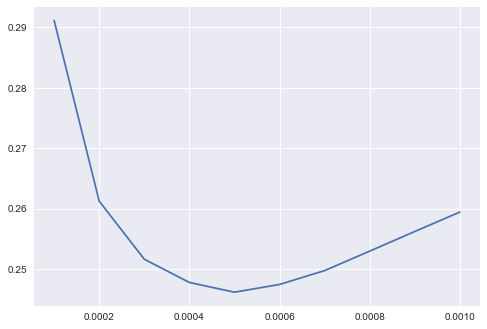

In [120]:
# brute force to find out the suitable parameter
re = lasso_fit(desc_df, train.price, np.linspace(1e-4, 1e-3, num=10), do_log=True).sort()
re

## num_estimators for GBDT

In [113]:
num_ests = list(range(50, 300, 5))
gbdt = []

for num_est in num_ests:
    gbdt.append((regressor(meta, train.price,
                           'GB', num_est=num_est, do_log=True), num_est))
gbdt.sort()
gbdt

[(44633.981817145359, 80),
 (44815.807193006738, 265),
 (44847.305440837881, 85),
 (44908.057419899116, 260),
 (44993.237870316691, 75),
 (45118.134110278676, 55),
 (45196.193654101291, 290),
 (45239.695580061198, 255),
 (45351.194208619105, 170),
 (45369.233907048401, 225),
 (45370.615922428391, 215),
 (45483.644597961094, 90),
 (45689.125302986678, 70),
 (45741.765686273829, 95),
 (45832.283849586318, 205),
 (45879.167801359828, 60),
 (45897.210519658845, 120),
 (45918.677998365114, 125),
 (45987.375757799389, 175),
 (45995.765766991208, 230),
 (46000.124253273374, 180),
 (46030.916738653897, 100),
 (46060.015304913963, 65),
 (46089.90042615922, 220),
 (46114.848971808955, 115),
 (46169.062156063526, 270),
 (46186.166718557957, 145),
 (46249.572531609694, 150),
 (46295.668663282835, 140),
 (46324.942555278591, 240),
 (46345.383897587963, 50),
 (46398.630784683672, 105),
 (46408.147796072546, 200),
 (46453.650586375988, 195),
 (46511.525126616543, 165),
 (46519.594642835691, 110),
 (4

In [171]:
print(regressor(desc_df, train.price, 'LR', n=80, alpha=5e-4, do_log=True))
print(regressor(desc_df, train.price, 'LASSO', n=-1, alpha=5e-4, do_log=True))
print(regressor(desc_df, train.price, 'GB', n=-1, num_est=500, do_log=True))

61597.7668874
61570.9241788
55046.2899017


## Combined meta and description

In [137]:
X = pd.concat([meta, desc_df], axis=1)

ns = range(100, 140, 3)
gb_tests = []
lasso_tests = []

for n in ns:
    gb_tests.append((regressor(X, train.price, 'GB', n), n))
    #lasso_tests.append((regressor(X, train.price, 'LASSO', n), n))
gb_tests.sort()
print(gb_tests[:10])
# lasso_tests.sort()
# print(lasso_tests[:10])

[(63847.192700319727, 106), (63851.787588027015, 112), (64241.975656413146, 100), (64629.615867194021, 115), (64635.99138072833, 121), (64768.638556104605, 103), (64915.850657843206, 127), (65257.915467022161, 130), (66101.644560194371, 109), (66289.608124269173, 139)]


In [170]:
ns = range(50, 150, 2)
lrs = []

for n in ns:
    lrs.append((regressor(X, train.price, 'LR', n=n, do_log=True), n))
lrs.sort()
lrs

[(52335.426423908575, 94),
 (52410.059493605804, 104),
 (52460.726945292517, 100),
 (52738.818096806899, 86),
 (52777.068324824984, 88),
 (52979.079556359953, 102),
 (52988.668229110233, 110),
 (53223.681250007809, 106),
 (53383.132205871472, 112),
 (53456.701801970172, 142),
 (53635.115400511029, 108),
 (53666.332682731401, 78),
 (53701.94921108475, 128),
 (53831.099712943695, 96),
 (53930.778415874564, 98),
 (53975.689002045736, 84),
 (54016.883042781046, 80),
 (54019.651412861655, 66),
 (54061.686536831992, 92),
 (54113.799696434289, 122),
 (54197.970962023173, 126),
 (54282.363562868362, 134),
 (54390.125523662238, 140),
 (54541.222399739272, 116),
 (54605.897952104315, 90),
 (54657.646184666955, 68),
 (54709.062464321694, 120),
 (54834.448756961443, 114),
 (55195.784849889533, 118),
 (55201.054092454411, 130),
 (55225.447191764113, 82),
 (55252.481249510733, 136),
 (55305.367387496808, 72),
 (55392.86604103008, 74),
 (55395.895299743032, 124),
 (55629.472180710814, 62),
 (55636.95

In [142]:
num_ests = list(range(200, 800, 10))
gbdt = []

for num_est in num_ests:
    gbdt.append((regressor(X, train.price,
                           'GB', num_est=num_est, n=120, do_log=True), num_est))
gbdt.sort()
gbdt

[(55896.929761067338, 640),
 (56018.599615282263, 260),
 (56046.189056629213, 330),
 (56236.121944357219, 560),
 (56479.142045177905, 750),
 (56513.078980063423, 580),
 (56529.552820330158, 430),
 (56630.924287370035, 240),
 (57046.353991952841, 790),
 (57129.074798972462, 270),
 (57132.579036478106, 350),
 (57264.306800423285, 490),
 (57289.258668318784, 320),
 (57322.766035212902, 770),
 (57350.072890774776, 390),
 (57451.918339535259, 620),
 (57541.363836748016, 710),
 (57557.492951507928, 480),
 (57584.900072322831, 680),
 (57658.085789528981, 670),
 (57740.163814815613, 380),
 (57800.356062508676, 720),
 (57803.228157778052, 470),
 (57929.079220419444, 300),
 (58012.99179434371, 600),
 (58072.970698669713, 500),
 (58095.177223109036, 280),
 (58108.768519771183, 440),
 (58195.602253575911, 520),
 (58210.622925149102, 450),
 (58234.566880417362, 540),
 (58243.068746094919, 420),
 (58299.626106015421, 250),
 (58397.534790319252, 690),
 (58414.90144415079, 200),
 (58456.981444352969, 

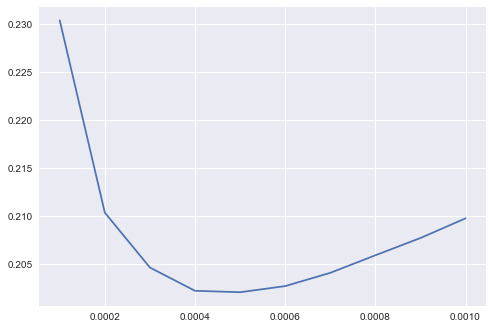

In [144]:
# brute force to find out the suitable parameter
re = lasso_fit(X, train.price, np.linspace(1e-4, 1e-3, num=10), do_log=True).sort()
re

In [172]:
print(regressor(X, train.price, 'LR', n=94, do_log=True))
print(regressor(X, train.price, 'LASSO', n=-1, do_log=True, alpha=4e-4))
print(regressor(X, train.price, 'GB', n=-1, do_log=True, num_est=640))

54278.4027925
48611.2173461
44309.0143396


## Single Feature Prediction

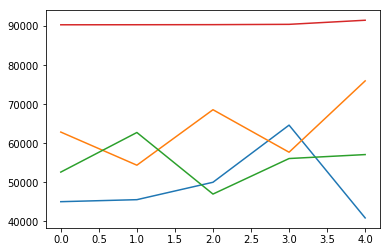

In [5]:
lasso_case1 = [45047.159659875426,45562.059863258255,
               50020.413622728825, 64649.495150247989,
               40892.382181324807]
lasso_case2 = [62873.187082618424,54390.049280796447,
               68594.773053683137,57710.761235445389,
               75974.512290344908]
lasso_case3 = [52624.629547744204,62762.013355321564,
               46999.410860853772,56096.305490243481,
               57108.94052944304]
lasso_case4 = [90339.28771158394,90351.82248387932,
               90373.80919018356,90452.41794065069,
               91502.60373323166]
plt.plot(range(0,5), lasso_case1,
         range(0,5), lasso_case2,
         range(0,5), lasso_case3,
         range(0,5), lasso_case4)
plt.show()

In [14]:
model, _ = get_model(meta, train.price, "GB", -1);

In [15]:
save_model(model, 'meta_model')

In [17]:
meta.shape

(753, 84)

In [5]:
meta

,cs_rating,en_rating,num_of_bathrooms,num_of_bedrooms,num_of_receptions,overall_rating,pr_rating,rs_rating,sp_rating,tt_rating,...,property_type_cottage,property_type_detached,property_type_detached_bungalow,property_type_end_terrace,property_type_flat,property_type_maisonette,property_type_semi_detached,property_type_semi_detached_bungalow,property_type_terraced,property_type_town_house
0,70,80,1.0,3.0,2.0,78,80,80,80,80,...,0,0,0,1,0,0,0,0,0,0
1,80,60,1.0,4.0,2.0,79,80,70,80,90,...,0,0,0,0,0,0,0,0,1,0
2,80,60,0.0,0.0,0.0,78,80,80,90,80,...,0,1,0,0,0,0,0,0,0,0
3,90,70,1.0,3.0,3.0,85,90,90,90,70,...,0,0,0,0,0,0,1,0,0,0
4,70,60,1.0,3.0,2.0,78,80,80,80,90,...,0,0,0,0,0,0,1,0,0,0
5,90,70,1.0,2.0,1.0,86,90,80,90,90,...,0,0,0,0,0,0,1,0,0,0
6,90,70,1.0,2.0,1.0,89,100,90,90,90,...,0,0,0,0,0,0,0,0,0,0
7,80,70,1.0,3.0,2.0,79,80,80,80,80,...,0,0,0,0,0,0,1,0,0,0
8,80,60,5.0,6.0,6.0,63,80,60,50,40,...,0,1,0,0,0,0,0,0,0,0
9,80,60,1.0,2.0,1.0,76,80,70,80,90,...,0,0,0,1,0,0,0,0,0,0


In [6]:
meta.mean()

cs_rating                                 77.649402
en_rating                                 69.110226
num_of_bathrooms                           1.252324
num_of_bedrooms                            2.924303
num_of_receptions                          1.413015
overall_rating                            78.980080
pr_rating                                 82.098274
rs_rating                                 77.104914
sp_rating                                 81.474104
tt_rating                                 84.741036
counciltax0                             1201.620186
counciltax1                             1401.723772
counciltax2                             1602.224436
counciltax3                             1802.693227
counciltax4                             2202.972112
counciltax5                             2603.670651
counciltax6                             3003.948207
counciltax7                             3604.699867
crime0                                    30.827795
crime1      

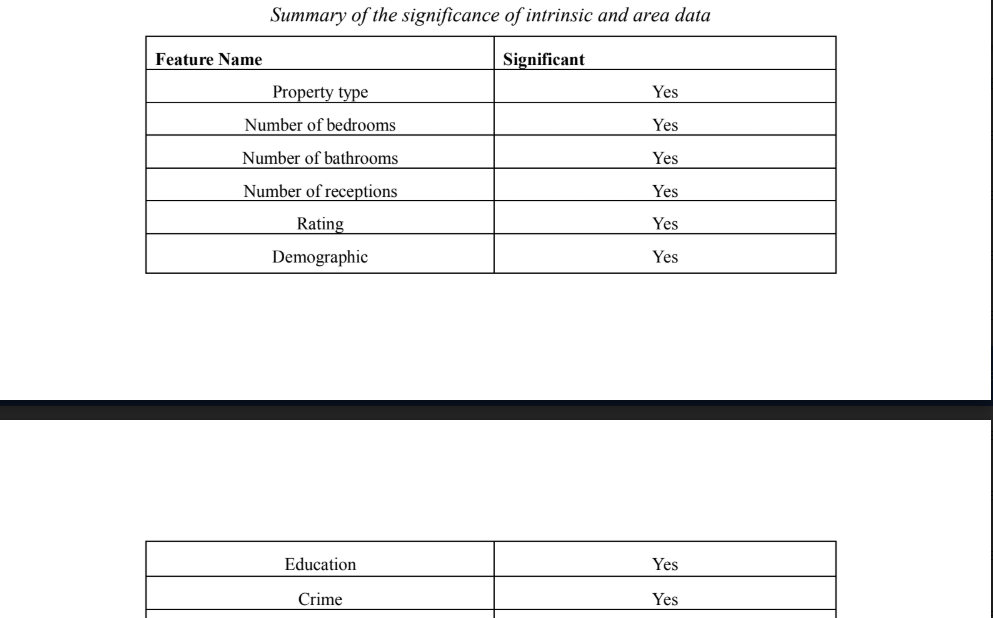

In [8]:
meta_mean = meta.mean()

In [21]:
useful_features = ['d', 'num_of', 'rating', 'demographic', 'education', 'crime']

In [35]:
re = []
sums = 0
counter = 0

for k, v in meta_mean.iteritems():
    if 'education' in k:
        print(k, v)
        sums += v
        counter += 1
sums / counter

education0 78.02523240371846
education1 21.349269588313412
education2 59.88300132802121
education3 91.2903054448874
education4 92.56055776892326


68.62167330677275